In this notebook, we will demonstrate how to plot memory functions using calculated IPC files. 
The previous script illustrates the total capacities of echo state network (ESN), but it does not show its dependency on delays. Here we explain first- and second-order memory functions using an ESN. 

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cupy as cp
from utils.information_processing_capacity import single_input_ipc

##### Parameters for esn #####
N = 50      # Number of nodes
Two = 10000 # Washout time
T = int(1e6)# Time length except washout
p = 0.5     # Sparsity for internal weight
pin = 0.1   # Sparsity for input weight
iota = 0.1  # Input intensity
rho = 0.5  # Spectral radius
#Weight
seed = 0
np.random.seed(seed)
win = (2*np.random.rand(N)-1) * (np.random.rand(N)<pin)
w = (2*np.random.rand(N,N)-1) * (np.random.rand(N,N)<p)
eig,eigv = np.linalg.eig(w)
w = w/np.max(np.abs(eig))

To depict both the first- and second-order memory functions, we employed an asymmetric input $u_t\in[0,1]$, which is injected to the ESN, because the ESN with a symmetric input holds only odd-order capacities. 
Note that a symmetric input $\zeta_t=2u_t-1\in[-1,1]$ is used for IPC calculation. 

In [3]:
##### Input #####
np.random.seed(0)
u = np.random.rand(Two+T)
print('Asymmetric input',u,u.shape)
zeta = 2*u-1
print('Symmetric input',zeta,zeta.shape)

# Parameters for IPC
poly = 'legendre'
distr = 'uniform'
degdelays = [[1,100],[2,30]]
# Class for IPC
ipc = single_input_ipc(zeta,Two,degdelays,poly=poly,distr=distr,zerobased=True)

gpu_id = 0
cp.cuda.Device(gpu_id).use()

# Directory
pkldir = 'ipc/pkl'
path = '%s/asym_%d_%5.3f_%5.3f_%5.3f_%5.3f'%(pkldir,N,p,pin,rho,iota)

Asymmetric input [0.5488135  0.71518937 0.60276338 ... 0.80933717 0.34843226 0.24151461] (1010000,)
Symmetric input [ 0.09762701  0.43037873  0.20552675 ...  0.61867435 -0.30313547
 -0.51697079] (1010000,)


In [10]:
# ESN
x = np.zeros((N,Two+T))
for t in range(1,Two+T):
    x[:,t] = np.tanh(rho*w.dot(x[:,t-1])+iota*win*u[t-1])

##### Compute IPC of ESN state #####
ipc.svd(x)
ipc.save_config(path)
Ctot = 0
for deg,delay in degdelays:
    ipcs,surs = ipc.compute(deg,delay)
    truncated = ipc.threshold(ipcs,surs,deg,delay,th_scale=1.2)
    Ctot_deg = np.sum(truncated['ipcs'].values)
    print('deg',deg,'delay',delay,'Ctot(d)',Ctot_deg)
    Ctot += Ctot_deg
print('degs',ipc.degs,'Ctot',Ctot,'rank',ipc.rank)
print('--------------------------------------------------------------------------------\n\n\n')

{'N': 50, 'T': 1000000, 'Two': 10000, 'Nseed': 200, 'degdelays': [[1, 100], [2, 30]], 'zerobased': True, 'poly': 'legendre', 'distr': 'uniform', 'thresh': 'N', 'finfo': 2.220446049250313e-16, 'rank': 47}
   degdelaysets      ipcs
1      [[1, 1]]  0.999998
2      [[1, 2]]  0.999998
3      [[1, 3]]  0.999998
4      [[1, 4]]  0.999998
5      [[1, 5]]  0.999998
6      [[1, 6]]  0.999998
7      [[1, 7]]  0.999998
8      [[1, 8]]  0.999997
9      [[1, 9]]  0.999997
10    [[1, 10]]  0.999993
11    [[1, 11]]  0.999988
12    [[1, 12]]  0.999958
13    [[1, 13]]  0.999765
14    [[1, 14]]  0.998323
15    [[1, 15]]  0.991900
16    [[1, 16]]  0.970086
17    [[1, 17]]  0.903928
18    [[1, 18]]  0.247113
19    [[1, 19]]  0.017166
20    [[1, 20]]  0.006050
21    [[1, 21]]  0.001101
22    [[1, 22]]  0.000263
23    [[1, 23]]  0.000103
deg 1 delay 100 Ctot(d) 17.135714654966076
           degdelaysets      ipcs
2              [[2, 1]]  0.974210
4              [[2, 2]]  0.975979
5      [[1, 1], [1, 2]]  0.

1. First-order memory function

The first-order memory function $C(\tau)$ describes an input delayed by $\tau$ held in a reservoir and is equivalent to the first-order IPC of $\zeta_{t-\tau}$. 
The method `single_input_ipc.mf1d()` returns the first-order memory function `mf1d` $\{C(\tau)\}$ with its corresponding delays `delays` $\{\tau\}$. 
Note that, when `zerobased`==True (False), the range of `delays` is from $0$ ($1$) to the maximum delay $\tau_{\rm max}$ in `degdelays` = [[1,$\tau_{\rm max}$]] . 

In [11]:
th_scale = 1.2
delays,mf1d = ipc.mf1d(path,th_scale=th_scale)
print('delay',delays)
print('1st-order capacties',mf1d)

delay [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100]
1st-order capacties [0, 0.9999977542079641, 0.999997757560886, 0.999997757745767, 0.9999977554985282, 0.9999977534632987, 0.9999977179031807, 0.9999976765368657, 0.9999973094011786, 0.9999967365450196, 0.99999298434968, 0.9999877934069917, 0.9999584780045646, 0.9997646254017665, 0.9983226140764189, 0.9918999439484403, 0.9700863281053578, 0.9039277011135582, 0.24711312908682, 0.017166378314716367, 0.006049823202667897, 0.001101197176021374, 0.00026290321733130344, 0.00010253669905183124, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

The capacities are selected by the shuffle surrogate method. 
In this method, we prepare $N_{\rm sur}(=200)$ target time-series shuffled in the time direction with different random seeds and calculate surrogates $C_{{\rm sur},i}~(i=1,\ldots,N_{\rm sur})$, which are capacities calculated with the $N_{\rm sur}$ shuffled targets.
If an original capacity $C(\tau)$ is statistically significant, $C(\tau)$ does not fall within the surrogate distribution. 
We set a threshold to $C_{\rm th}=scale\times\max_i(C_{{\rm sur},i})$ and select $C(\tau)$ greater than $C_{\rm th}$. 
Note that $C(\tau)~(\tau=0,1,\ldots)$ share the threshold $C_{\rm th}$ because we assume that the input sequence is stationary and thus statistical properties of shuffled delayed input series $\{\zeta_{t-\tau}\}$ (e.g., mean and variance) are independent of $\tau$. 

Threshold 0.00010109611928902092


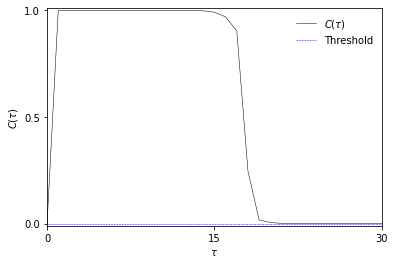

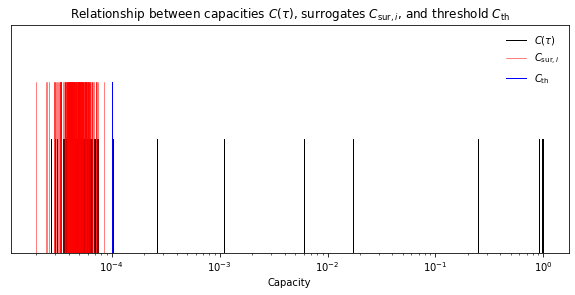

In [12]:
# If you would like to get the surrogates and threshold, 'return_original' should be set to True. 
th_scale = 1.2
delays,mf1d,ipcs,surs = ipc.mf1d(path,th_scale=th_scale,return_original=True)
ipcs = ipcs['ipcs'].values
surs = surs.values[0]
thr = th_scale*surs.max()
print('Threshold',thr)

plt.figure()
plt.plot(delays,mf1d,'k-',lw=0.5,label=r'$C(\tau)$')
plt.plot([delays.min(),delays.max()],[thr,thr],'b--',lw=0.5,label='Threshold')
plt.xlim(0,25)
plt.xlabel(r'$\tau$')
plt.xticks([0,15,30])
plt.ylim(-0.01,1.01)
plt.ylabel(r'$C(\tau)$')
plt.yticks([0,0.5,1])
plt.legend(loc='upper right',frameon=False)
plt.savefig('sample2_1d_memory_function.png',dpi=300,facecolor="w",edgecolor="w")

plt.figure(figsize=[10,4.2])
# Capacities
plt.plot(ipcs[0]*np.ones(2),[0,1],'k-',lw=1,label=r'$C(\tau)$')
[ plt.plot(c*np.ones(2),[0,1],'k-',lw=1) for c in ipcs[1:]]
# Surrogates
plt.plot(surs[0]*np.ones(2),[0,1.5],'r-',lw=0.5,label=r'$C_{{\rm sur},i}$')
[ plt.plot(c*np.ones(2),[0,1.5],'r-',lw=0.5) for c in surs[1:]]
# Threshold
plt.plot(thr*np.ones(2),[0,1.5],'b-',lw=1,label=r'$C_{\rm th}$')
plt.xlabel('Capacity')
plt.xscale('log')
plt.ylim(0,2)
plt.yticks([])
plt.legend(loc='upper right',frameon=False)
plt.title(r'Relationship between capacities $C(\tau)$, surrogates $C_{{\rm sur},i}$, and threshold $C_{\rm th}$')
plt.savefig('sample2_1d_surrogate.png',dpi=300,facecolor="w",edgecolor="w")


2. Second-order memory function

The second-order memory function $C(\tau_1,\tau_2)$ represents the second-order IPC of $\zeta_{t-\tau_1}\zeta_{t-\tau_2}$ held in a reservoir. 
The method `single_input_ipc.mf2d()` returns the second-order memory function `mf2d` $\{C(\tau_1,\tau_2)\}$ with its corresponding delays `delays` $\{\tau\}$. 
In the same manner as the first-order, when `zerobased`==True (False), the range of `delays` is from $0$ ($1$) to the maximum delay $\tau_{\rm max}$ in `degdelays` = [[2, $\tau_{\rm max}$]]. 

In [13]:
th_scale = 1.2
delays,mf2d = ipc.mf2d(path,th_scale=th_scale)
print(delays,mf2d)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30] [[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [           nan 9.74210484e-01 9.41359554e-01 9.34812339e-01
  9.42365286e-01 1.10164417e-01 3.91091273e-01 3.23262826e-02
  1.91128954e-03 2.56565563e-03 4.06098944e-04 1.10533454e-04
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.0

The targets of the second-order capacities are expressed in the form of two types of polynomials. 
Let two delays of the second-order polynomial be $\tau_1,\tau_2$, and the orthogonal polynomials are represented by $z_t=(3\zeta_{t-\tau_1}^2-1)/2$ ($\tau_1=\tau_2$) and $z_t=\zeta_{t-\tau_1}\zeta_{t-\tau_2}$ ($\tau_1\neq\tau_2$). 
We need to calculate $N_{\rm sur}$ surrogates for each polynomial shape because shuffled time-series of different polynomials generally do not share the same statistical properties. 

Diagonal capacities [5.48020502e-05 9.74210484e-01 9.75978860e-01 9.75004591e-01
 9.69292886e-01 9.32941290e-01 8.42541837e-01 7.63535608e-01
 1.35300214e-01 2.06409001e-02 7.75010976e-03 1.24680021e-03
 1.02132042e-04 6.77263772e-05 6.81747231e-05 6.92936796e-05
 6.18212997e-05 6.49193330e-05 6.02327811e-05 6.62001511e-05
 5.90606954e-05 4.98931107e-05 4.79622717e-05 5.21744994e-05
 4.30264881e-05 4.32164937e-05 4.04201039e-05 4.77081368e-05
 4.45422860e-05 6.23649404e-05 5.24065909e-05] (31,)
Non-diagonal capacities [5.68358185e-05 5.61359723e-05 4.57817503e-05 7.08204851e-05
 5.98852993e-05 7.16843293e-05 7.38728528e-05 5.83911492e-05
 4.17044896e-05 3.44297996e-05 5.54942241e-05 4.56179312e-05
 5.25099874e-05 4.90998010e-05 4.81941139e-05 5.28715042e-05
 4.22338741e-05 6.68957541e-05 4.96283026e-05 3.03966276e-05
 6.71985429e-05 6.01351385e-05 5.03710078e-05 5.88044239e-05
 5.12387733e-05 5.22260251e-05 6.79555973e-05 5.10048351e-05
 4.81178078e-05 4.26387985e-05 9.41359554e-01 9.3

/tmp/ipykernel_3333849/1558163395.py:19: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  c = ax.pcolor(delays,delays,mf2d)


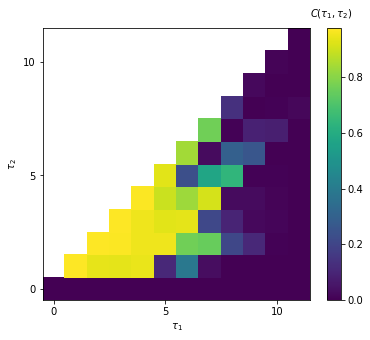

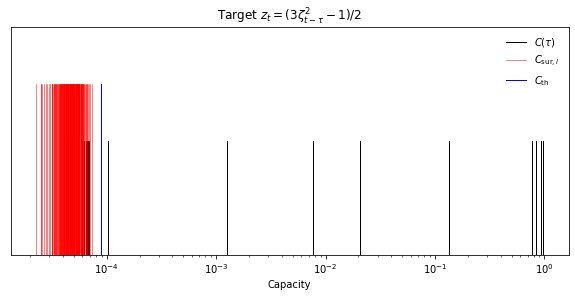

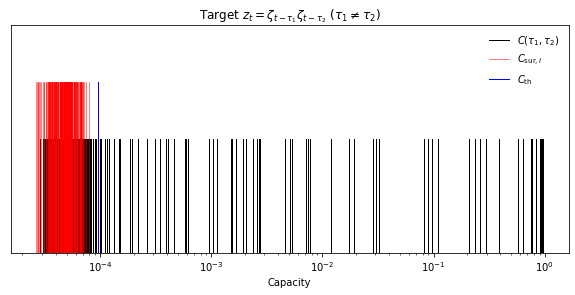

In [14]:
th_scale = 1.2
delays,mf2d,mf2d_original,surs = ipc.mf2d(path,th_scale=th_scale,return_original=True)

# Diagonal case (i.e., \tau_1=\tau_2)
ipcs_diag = np.diag(mf2d_original)
# Non-diagonal case (i.e., \tau_1\neq\tau_2)
ipcs_nondiag = mf2d_original[np.tri(mf2d_original.shape[0],k=-1).T>0]
print('Diagonal capacities',ipcs_diag,ipcs_diag.shape)
print('Non-diagonal capacities',ipcs_nondiag,ipcs_nondiag.shape)

sur_degdelays = surs.index.values
surs = surs.values
print('Surrogates')
for l,dd,s in zip(['Diagonal','Non-diagonal'],sur_degdelays,surs):
    print(l,dd,s.shape)

# Plot ipc decomposition
fig,ax = plt.subplots(figsize=(6,5))
c = ax.pcolor(delays,delays,mf2d)
fig.colorbar(c, ax=ax) 
ax.set_xlim(0,12)
ax.set_ylim(0,12)
ax.set_xlabel(r'$\tau_1$')
ax.set_ylabel(r'$\tau_2$')
ax.set_xticks([0.5,5.5,10.5])
ax.set_xticklabels([0,5,10])
ax.set_yticks([0.5,5.5,10.5])
ax.set_yticklabels([0,5,10])
ax.text(12,12.5,r'$C(\tau_1,\tau_2)$')
plt.savefig('sample2_2d_memory_function.png',dpi=300,facecolor="w",edgecolor="w")

# Plot the surrogates and threshold of diagonal capacities
thr = th_scale*surs[0].max()
plt.figure(figsize=[10,4.2])
plt.plot(ipcs_diag[0]*np.ones(2),[0,1],'k-',lw=1,label=r'$C(\tau)$')
[ plt.plot(c*np.ones(2),[0,1],'k-',lw=1) for c in ipcs_diag[1:]]
plt.plot(surs[0][0]*np.ones(2),[0,1.5],'r-',lw=0.5,label=r'$C_{{\rm sur},i}$')
[ plt.plot(c*np.ones(2),[0,1.5],'r-',lw=0.5) for c in surs[0][1:]]
plt.plot(thr*np.ones(2),[0,1.5],'b-',lw=1,label=r'$C_{\rm th}$')
plt.xlabel('Capacity')
plt.xscale('log')
plt.ylim(0,2)
plt.yticks([])
plt.legend(loc='upper right',frameon=False)
plt.title(r'Target $z_t=(3\zeta_{t-\tau}^2-1)/2$')
plt.show()

# Plot the surrogates and threshold of non-diagonal capacities
thr = th_scale*surs[1].max()
plt.figure(figsize=[10,4.2])
plt.plot(ipcs_nondiag[0]*np.ones(2),[0,1],'k-',lw=1,label=r'$C(\tau_1,\tau_2)$')
[ plt.plot(c*np.ones(2),[0,1],'k-',lw=1) for c in ipcs_nondiag[1:]]
plt.plot(surs[1][0]*np.ones(2),[0,1.5],'r-',lw=0.5,label=r'$C_{{\rm sur},i}$')
[ plt.plot(c*np.ones(2),[0,1.5],'r-',lw=0.5) for c in surs[1][1:]]
plt.plot(thr*np.ones(2),[0,1.5],'b-',lw=1,label=r'$C_{\rm th}$')
plt.xlabel('Capacity')
plt.xscale('log')
plt.ylim(0,2)
plt.yticks([])
plt.legend(loc='upper right',frameon=False)
plt.title(r'Target $z_t=\zeta_{t-\tau_1}\zeta_{t-\tau_2}~(\tau_1\neq\tau_2)$')
plt.show()
